# Decision Tree Classifier Model for predicting wildfire causes
This notebook demonstrates the process of using a Decision Tree Classifier to predict the causes of wildfires. The analysis includes data loading, preprocessing, model training, evaluation, and comparison of results across different data balancing techniques.


## Abstract

| Original Dataset | Random Under-Sampling (RUS)             | SMOTE             | KFold Cross Validation (Original Dataset) |
|------------------|--------------------|-------------------|-------------------------------------------|
| Accuracy: 0.5394 | Accuracy: 0.3207   | Accuracy: 0.5099  | Accuracy: 0.5424                          |

## Analysis Overview

1. **Data Loading and Preprocessing:** The cleaned dataset is loaded, and labels are extracted. The dataset is checked for balance.
2. **Data Balancing:** Two techniques, ADASYN and SMOTE, are applied to balance the dataset. The model's performance is compared across the original, ADASYN-balanced, and SMOTE-balanced datasets.
3. **Model Training and Evaluation:** The Decision Tree Classifier is trained on the original and balanced datasets. Performance is evaluated using accuracy, confusion matrix, and classification report metrics.
4. **KFold Cross-Validation:** To ensure robustness, KFold cross-validation is applied, providing a comprehensive evaluation across different dataset splits.
5. **Result Comparison:** The model's performance is compared across the different datasets to assess the impact of data balancing on predictive accuracy.

### Insights:

- The Decision Tree Classifier shows a notable difference in performance when trained on balanced vs. unbalanced datasets, highlighting the importance of addressing class imbalance in predictive modeling.
- Cross-validation results provide a holistic view of the model's performance, indicating its generalizability across various data splits.
- The comparison across different balancing techniques and the original dataset offers valuable insights into the trade-offs and benefits of each approach in the context of wildfire cause prediction.

## Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import ADASYN
import os
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler


## Load Dataset

In [4]:
# Load and prepare the dataset
df = pd.read_csv('cleaned_data.csv')
labels = np.array(df.pop('STAT_CAUSE_DESCR'))

print(labels.shape)
print(df.shape)

#print unique labels
print(np.unique(labels))

#load encoded data
with open('encoders/STAT_CAUSE_DESCR_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

#decode the labels
labels = encoder.inverse_transform(labels)
print(np.unique(labels))


(445955,)
(445955, 22)
[ 0  1  2  3  4  5  6  7  8  9 10]
['Arson' 'Campfire' 'Children' 'Debris Burning' 'Equipment Use'
 'Fireworks' 'Lightning' 'Powerline' 'Railroad' 'Smoking' 'Structure']


c:\Users\adirb\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Check if Dataset is balanced

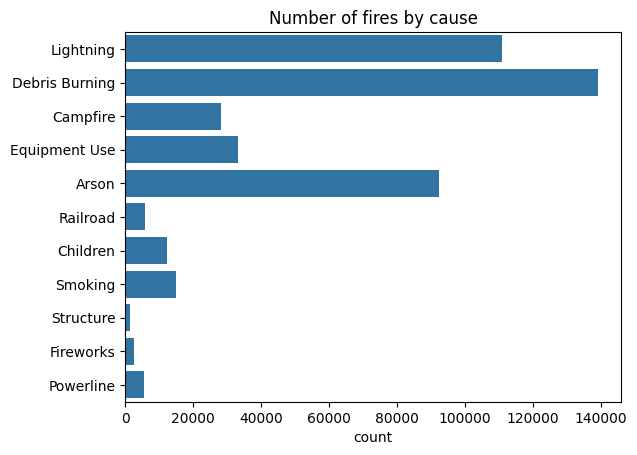

In [5]:
sns.countplot(labels)
plt.title('Number of fires by cause')
plt.show()

We can see above that the dataset is imbalanced. We will use two techniques to balance the dataset: ADASYN and SMOTE. We will then compare the results of the Decision Tree Classifier model trained on the original dataset, the dataset balanced with ADASYN, and the dataset balanced with SMOTE.

In [6]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)



(285411, 22) (71353, 22) (89191, 22)


## check if  training is balanced

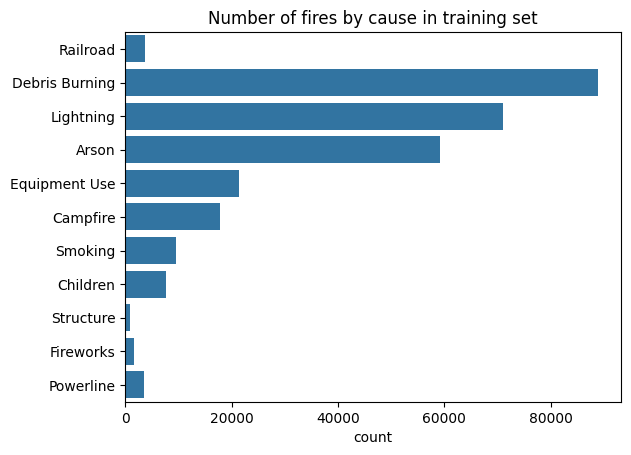

In [7]:
sns.countplot(y_train)
plt.title('Number of fires by cause in training set')
plt.show()

## Balance the dataset using ADASYN
The following code checks if the balanced dataset files exist. If they do, the balanced training data is loaded. If not, the ADASYN algorithm is used to balance the training set. The balanced training data is then saved to the 'ADASYN Balanced Dataset' directory.

Class distribution after balancing: Counter({'Arson': 95431, 'Railroad': 89805, 'Powerline': 89720, 'Fireworks': 88977, 'Structure': 88960, 'Debris Burning': 88808, 'Children': 87491, 'Equipment Use': 87486, 'Smoking': 86176, 'Lightning': 85891, 'Campfire': 84011})


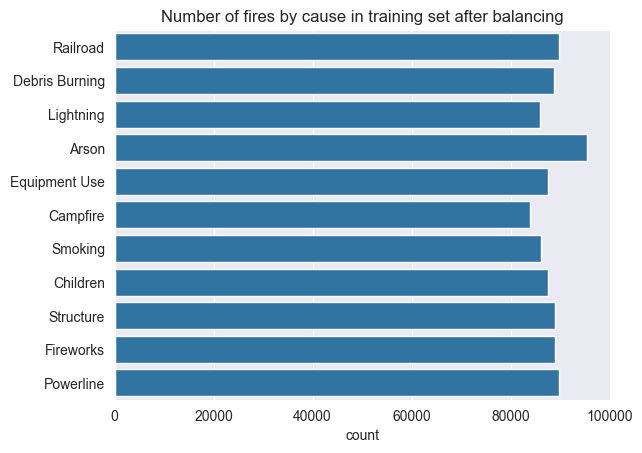

In [7]:
# Check if the balanced dataset files exist
if os.path.exists('ADASYN Balanced Dataset/X_train_balanced.npy') and os.path.exists('ADASYN Balanced Dataset/y_train_balanced.npy'):
    # Load the balanced training data
    X_train_ADASYN = np.load('ADASYN Balanced Dataset/X_train_balanced.npy', allow_pickle=True)
    y_train_ADASYN = np.load('ADASYN Balanced Dataset/y_train_balanced.npy', allow_pickle=True)

    print("Balanced dataset loaded.")
else:
    # Instantiate ADASYN
    adasyn = ADASYN(random_state=42)

    # Perform over-sampling with ADASYN
    X_train_ADASYN, y_train_ADASYN = adasyn.fit_resample(X_train, y_train)

    print(f"Class distribution after balancing: {Counter(y_train_ADASYN)}")

    # Plot the distribution after balancing
sns.countplot(y_train_ADASYN)
plt.title('Number of fires by cause in training set after balancing')
plt.show()

Class distribution after SMOTE: Counter({'Railroad': 88808, 'Debris Burning': 88808, 'Lightning': 88808, 'Arson': 88808, 'Equipment Use': 88808, 'Campfire': 88808, 'Smoking': 88808, 'Children': 88808, 'Structure': 88808, 'Fireworks': 88808, 'Powerline': 88808})


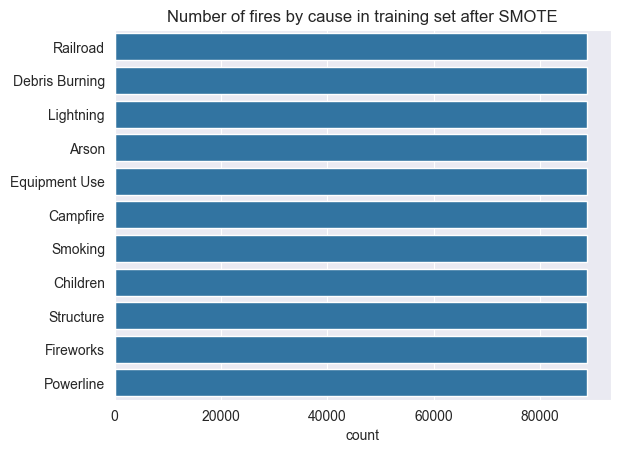

Balanced dataset saved.


In [8]:
# Check if the balanced dataset files exist
if os.path.exists('SMOTE_Balanced_Dataset/X_train_smote.npy') and os.path.exists('SMOTE_Balanced_Dataset/y_train_smote.npy'):
    # Load the balanced training data
    X_train_smote = np.load('SMOTE_Balanced_Dataset/X_train_smote.npy', allow_pickle=True)
    y_train_smote = np.load('SMOTE_Balanced_Dataset/y_train_smote.npy', allow_pickle=True)
    
    print("Balanced dataset loaded.")
else:
    # Apply SMOTE to balance the training set
    sm = SMOTE(random_state=42)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    print(f"Class distribution after SMOTE: {Counter(y_train_smote)}")

    # Plot the distribution after SMOTE
sns.countplot(y_train_smote)
plt.title('Number of fires by cause in training set after SMOTE')
plt.show()

# Define the directory path to save the balanced dataset
save_dir = 'SMOTE_Balanced_Dataset'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the balanced training data
np.save(os.path.join(save_dir, 'X_train_smote.npy'), X_train_smote)
np.save(os.path.join(save_dir, 'y_train_smote.npy'), y_train_smote)

print("Balanced dataset saved.")

# Using Random Under-Sampling to Balance Training Set

Original training data: 285411 samples
RUSed training data: 9790 samples


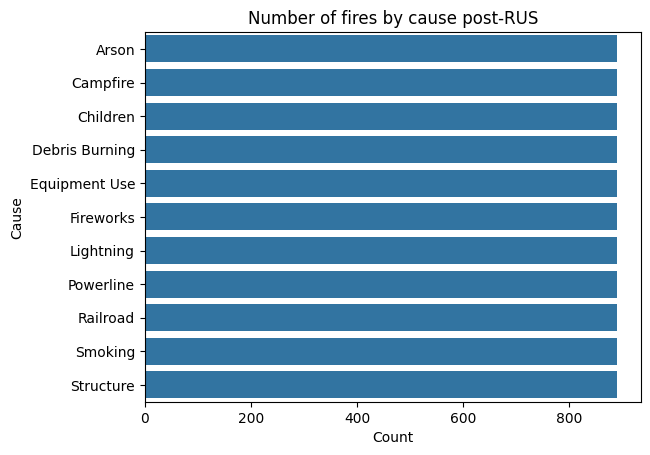

In [8]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f'Original training data: {X_train.shape[0]} samples')
print(f'RUSed training data: {X_train_rus.shape[0]} samples')

sns.countplot(y_train_rus)
plt.title('Number of fires by cause post-RUS')
plt.xlabel('Count')
plt.ylabel('Cause')
plt.show()

## Define hyperparameters

In [11]:
## Define hyperparameters
hyperparams = {
    'max_depth': None,  # or specify an integer value
    'min_samples_leaf': 1,  # or specify an integer value
    'min_samples_split': 2  # or specify an integer value
}

# Train Using Random Forest Classifier with RUS to Balance Training Set
RUS = Random Under-Sampling

In [12]:
# train model with random forest
dt_clf = DecisionTreeClassifier(**hyperparams)
dt_clf.fit(X_train_rus, y_train_rus)

# Evaluate the model on the test set
y_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.3207


                precision    recall  f1-score   support

         Arson       0.50      0.30      0.37     18349
      Campfire       0.25      0.39      0.30      5765
      Children       0.06      0.21      0.09      2398
Debris Burning       0.56      0.22      0.32     27826
 Equipment Use       0.19      0.22      0.20      6570
     Fireworks       0.07      0.46      0.11       517
     Lightning       0.81      0.50      0.62     22192
     Powerline       0.06      0.30      0.10      1096
      Railroad       0.05      0.34      0.09      1166
       Smoking       0.09      0.23      0.13      3049
     Structure       0.02      0.40      0.04       263

      accuracy                           0.32     89191
     macro avg       0.24      0.33      0.22     89191
  weighted avg       0.52      0.32      0.37     89191



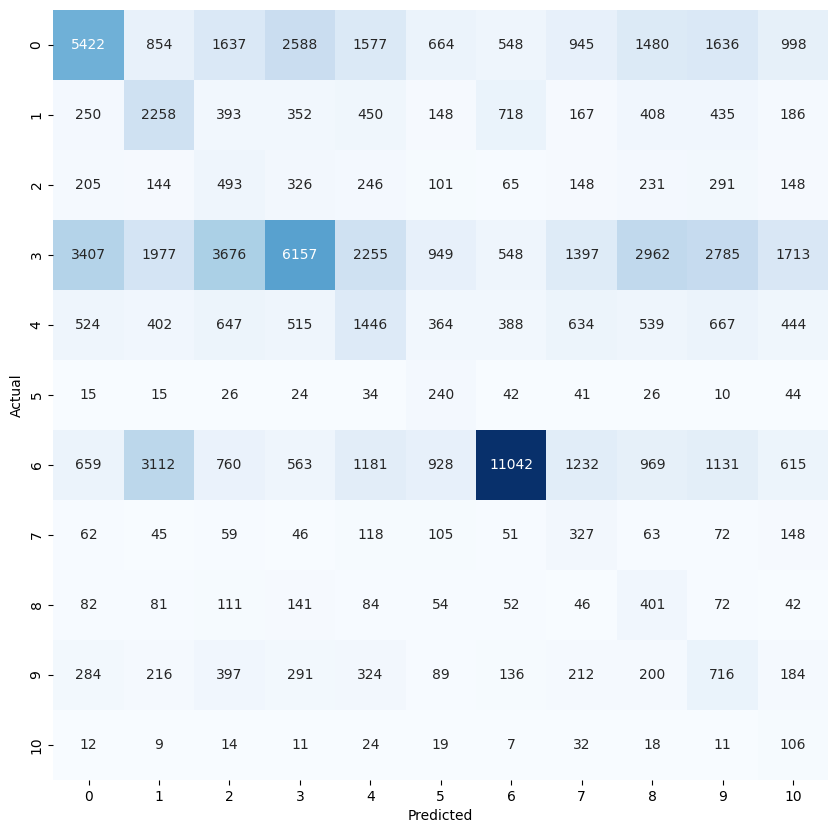

In [13]:
# plot results
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, y_pred))

## Train using original dataset

In [10]:
dt_clf = DecisionTreeClassifier(**hyperparams)
dt_original = dt_clf.fit(X_train, y_train)

#evaluate model on test set
y_test_pred_original = dt_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_test_pred_original)
class_report_original = classification_report(y_test, y_test_pred_original)
print('Test Accuracy (Original Dataset):', accuracy_original)

Test Accuracy (Original Dataset): 0.5394490475496406


## Plot results for original dataset

                precision    recall  f1-score   support

         Arson       0.51      0.51      0.51     18349
      Campfire       0.39      0.38      0.39      5765
      Children       0.10      0.11      0.10      2398
Debris Burning       0.59      0.57      0.58     27826
 Equipment Use       0.29      0.30      0.30      6570
     Fireworks       0.17      0.18      0.17       517
     Lightning       0.79      0.78      0.78     22192
     Powerline       0.12      0.14      0.13      1096
      Railroad       0.27      0.30      0.28      1166
       Smoking       0.16      0.17      0.16      3049
     Structure       0.03      0.04      0.03       263

      accuracy                           0.54     89191
     macro avg       0.31      0.32      0.31     89191
  weighted avg       0.54      0.54      0.54     89191


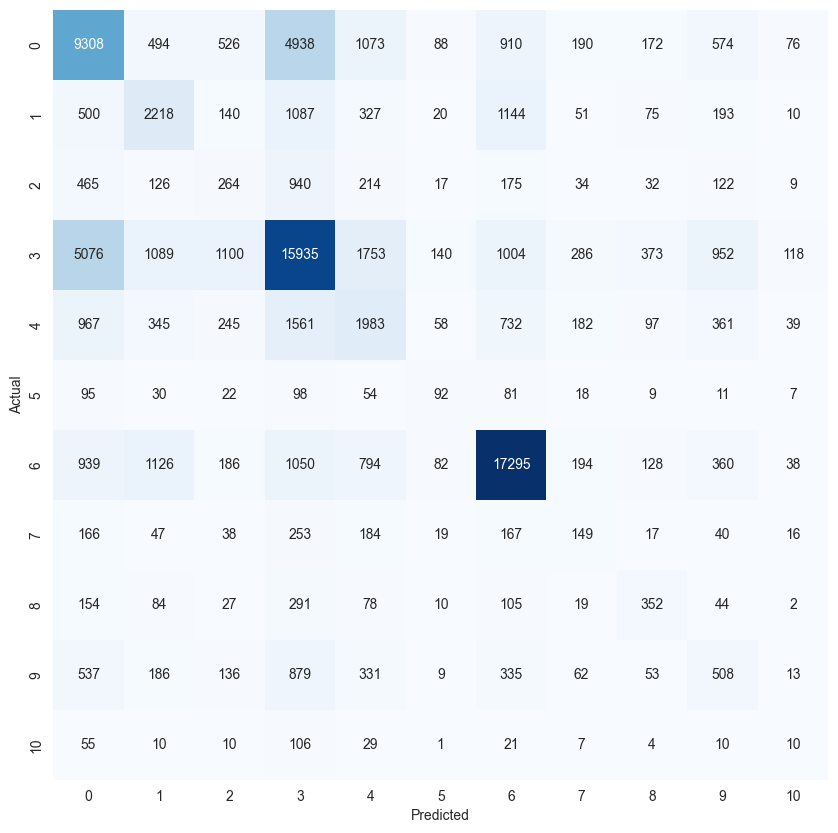

In [11]:
# plot results
cm = confusion_matrix(y_test, y_test_pred_original)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, y_test_pred_original))


In [12]:
#Save the model
with open('decision_tree_model_original.pkl', 'wb') as f:
    pickle.dump(dt_original, f)

## Train using ADASYN

In [13]:
# Fit the classifier on the balanced training data with ADASYN
dt_with_ADASYN = dt_clf.fit(X_train_ADASYN, y_train_ADASYN)

# Evaluate the model on the validation set
y_val_pred_ADASYN = dt_with_ADASYN.predict(X_val)
accuracy_ADASYN = accuracy_score(y_val, y_val_pred_ADASYN)
class_report_ADASYN = classification_report(y_val, y_val_pred_ADASYN)
conf_matrix_ADASYN = confusion_matrix(y_val, y_val_pred_ADASYN)

print("Test Accuracy (ADASYN):", accuracy_ADASYN)




Test Accuracy (ADASYN): 0.5015906829425533


## Plot results for ADASYN

                precision    recall  f1-score   support

         Arson       0.50      0.48      0.49     14714
      Campfire       0.34      0.41      0.37      4532
      Children       0.10      0.16      0.12      2066
Debris Burning       0.59      0.49      0.54     22418
 Equipment Use       0.26      0.31      0.29      5147
     Fireworks       0.17      0.30      0.22       438
     Lightning       0.79      0.73      0.76     17631
     Powerline       0.10      0.17      0.12       869
      Railroad       0.22      0.34      0.27       948
       Smoking       0.13      0.19      0.15      2371
     Structure       0.04      0.10      0.06       219

      accuracy                           0.50     71353
     macro avg       0.30      0.33      0.31     71353
  weighted avg       0.54      0.50      0.52     71353


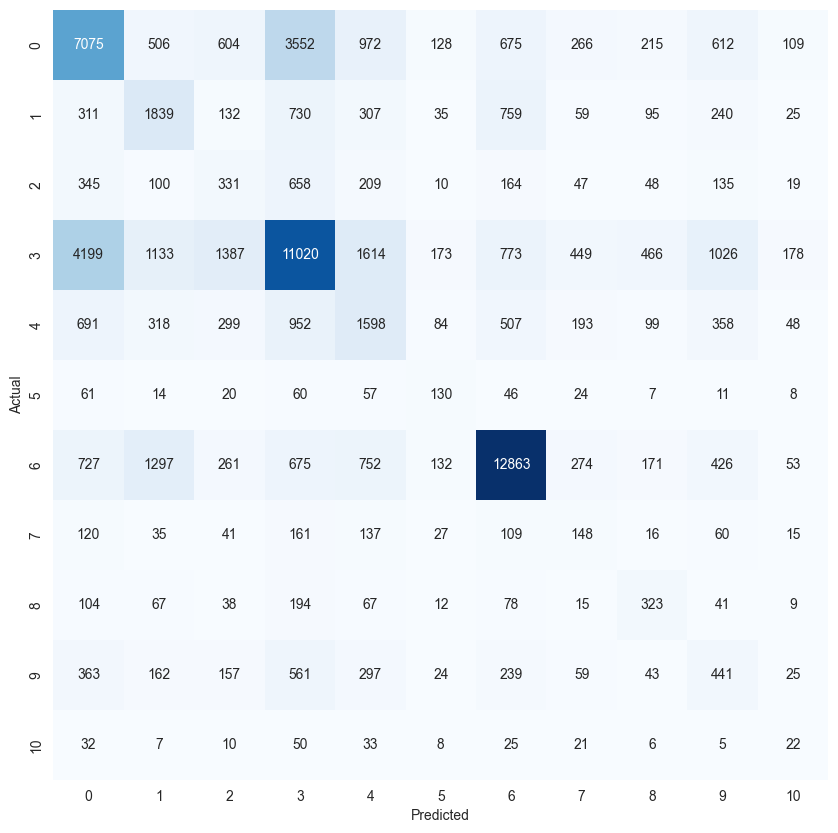

In [14]:
# Plot Results for ADASYN
cm = confusion_matrix(y_val, y_val_pred_ADASYN)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
print(classification_report(y_val, y_val_pred_ADASYN))

In [15]:
#Save the model
with open('decision_tree_model_ADASYN.pkl', 'wb') as f:
    pickle.dump(dt_with_ADASYN, f)

## Train using SMOTE

In [16]:
# Fit the classifier on the balanced training data with SMOTE
dt_with_SMOTE = dt_clf.fit(X_train_smote, y_train_smote)

# Evaluate the model on the validation set
y_val_pred_SMOTE = dt_with_SMOTE.predict(X_val)
accuracy_SMOTE = accuracy_score(y_val, y_val_pred_SMOTE)
class_report_SMOTE = classification_report(y_val, y_val_pred_SMOTE)
conf_matrix_smote = confusion_matrix(y_val, y_val_pred_SMOTE)

print("Test Accuracy (SMOTE):", accuracy_SMOTE)

Test Accuracy (SMOTE): 0.5098594312782925


                precision    recall  f1-score   support

         Arson       0.52      0.49      0.50     14714
      Campfire       0.35      0.42      0.38      4532
      Children       0.10      0.15      0.12      2066
Debris Burning       0.61      0.51      0.55     22418
 Equipment Use       0.27      0.32      0.30      5147
     Fireworks       0.14      0.24      0.18       438
     Lightning       0.80      0.73      0.76     17631
     Powerline       0.10      0.17      0.12       869
      Railroad       0.21      0.33      0.25       948
       Smoking       0.14      0.20      0.17      2371
     Structure       0.03      0.08      0.05       219

      accuracy                           0.51     71353
     macro avg       0.30      0.33      0.31     71353
  weighted avg       0.55      0.51      0.53     71353


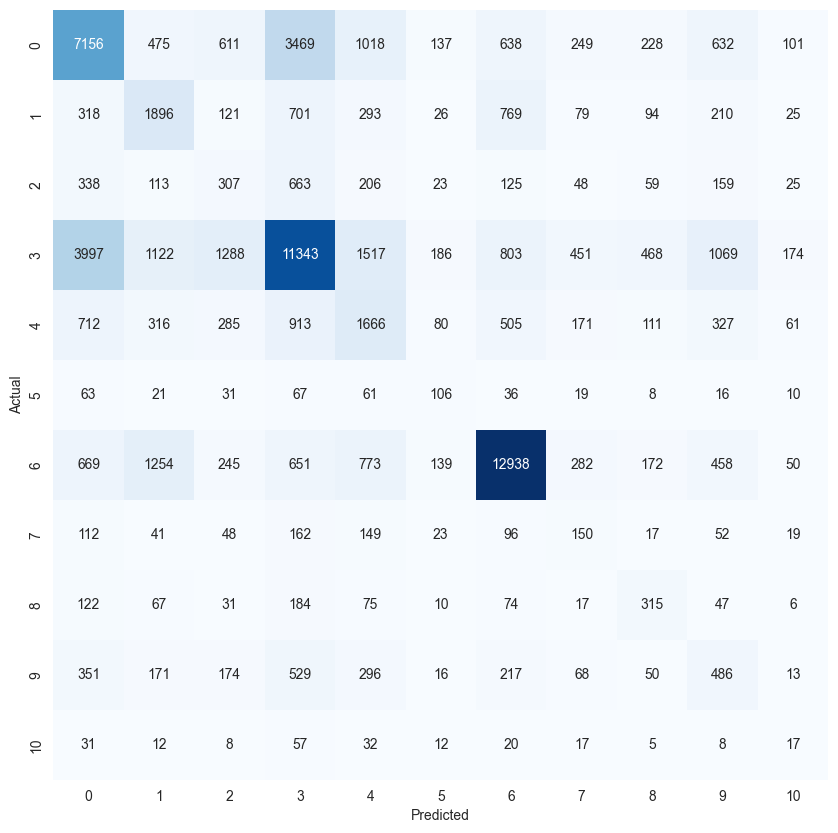

In [17]:
# Plot Results for SMOTE
cm = confusion_matrix(y_val, y_val_pred_SMOTE)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
print(classification_report(y_val, y_val_pred_SMOTE))

In [18]:
#Save the model
with open('decision_tree_model_smote.pkl', 'wb') as f:
    pickle.dump(dt_with_SMOTE, f)

# Train usig K-Fold Cross Validation with Decision Tree Classifier
To ensure the robustness of our model, we apply K-Fold Cross-Validation. This technique provides a thorough assessment of the model's performance across different subsets of the dataset.

In [19]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []  # To store accuracies for each fold

for fold_index, (train_indices, test_indices) in enumerate(skf.split(df, labels), 1):
    print(f"Fold {fold_index}:")
    print("--------")

    X_train_val, X_test = df.iloc[train_indices], df.iloc[test_indices]
    y_train_val, y_test = labels[train_indices], labels[test_indices]

    # Train the model with best hyperparameters on the entire training + validation set
    dt_clf.fit(X_train_val, y_train_val)

    # Evaluate model on the test set
    y_pred = dt_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    print(f"Accuracy for fold {fold_index}: {accuracy:.4f}\n")

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracies)
print(f"Average Accuracy across all folds: {avg_accuracy:.4f}")
    

Fold 1:
--------
Accuracy for fold 1: 0.5391

Fold 2:
--------
Accuracy for fold 2: 0.5426

Fold 3:
--------
Accuracy for fold 3: 0.5440

Fold 4:
--------
Accuracy for fold 4: 0.5431

Fold 5:
--------
Accuracy for fold 5: 0.5434

Average Accuracy across all folds: 0.5424


# Plot results for K-Fold Cross Validation for each scenario

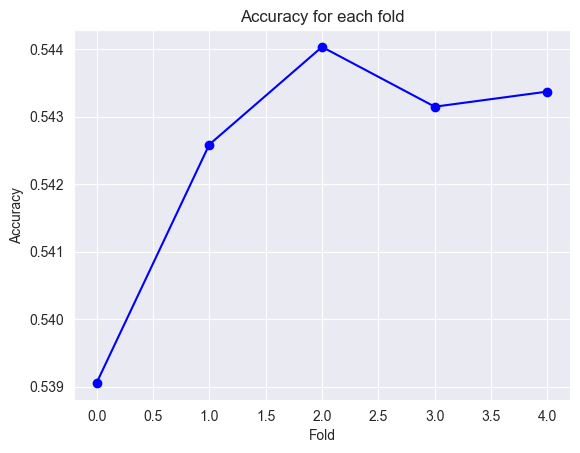

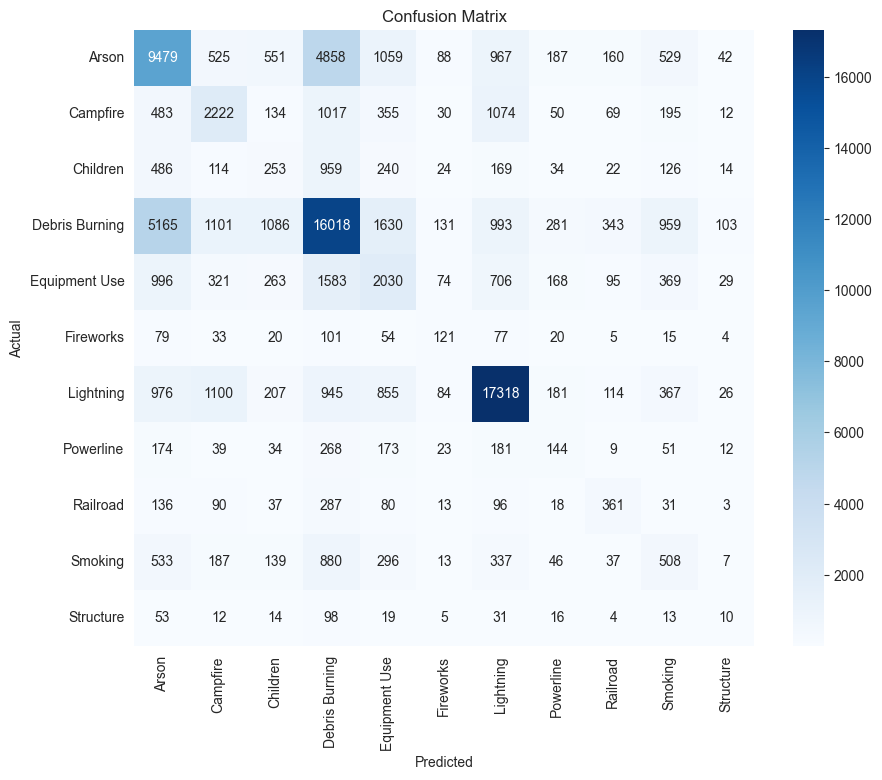

                precision    recall  f1-score   support

         Arson       0.51      0.51      0.51     18445
      Campfire       0.39      0.39      0.39      5641
      Children       0.09      0.10      0.10      2441
Debris Burning       0.59      0.58      0.58     27810
 Equipment Use       0.30      0.31      0.30      6634
     Fireworks       0.20      0.23      0.21       529
     Lightning       0.79      0.78      0.79     22173
     Powerline       0.13      0.13      0.13      1108
      Railroad       0.30      0.31      0.30      1152
       Smoking       0.16      0.17      0.17      2983
     Structure       0.04      0.04      0.04       275

      accuracy                           0.54     89191
     macro avg       0.32      0.32      0.32     89191
  weighted avg       0.55      0.54      0.55     89191


In [20]:
# Plot the results for K-Fold Cross Validation
plt.plot(accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for each fold')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))
